In [ ]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import datetime
import joblib

from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from io import StringIO

import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
# load the tab used for embedding, only the training set of course

with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/train_set.pkl", 'rb') as f:
  overall_train_set = pickle.load(f)

# index reset is important for the stratified splitting and the saving to lists
overall_train_set.reset_index(drop=True, inplace=True)

In [ ]:
# ##############################
# # CRASHES!!!
# with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/xgb_pkl8020.pkl", 'rb') as f:
#   xgb_class = pickle.load(f)

# # xgb_class = joblib.load("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/xgb_joblib8020.joblib")
# # xgb_class

In [ ]:
overall_train_set["representative"].nunique()

10894

In [ ]:
overall_train_set_no_embed = overall_train_set.drop(["embeddings"], axis=1)
overall_train_set_no_embed

,code,nsub,QSBIO_err_prob,best_BU,homo,pdb_code,fasta,representative
0,5ahz_1,3.0,0.0,1.0,1.0,5ahz,A A A V R E N A L L S S S L W V N V A L A G I ...,2jaf_1
1,3q6m_1,6.0,0.0,1.0,1.0,3q6m,A A T K P I W T R N P D D I T N E E Y G E F Y ...,2cge_1
2,1luq_1,4.0,0.0,1.0,1.0,1luq,A E A G I T G T W Y N Q L G S T F I V T A G A ...,3wzn_1
3,3t6f_1,4.0,0.0,1.0,1.0,3t6f,A E A G I T G T W Y N Q L G S T F I V T A G A ...,3wzn_1
4,1srf_1,4.0,0.0,1.0,1.0,1srf,A E A G I T G T W Y N Q L G S T F I V T A G A ...,3wzn_1
...,...,...,...,...,...,...,...,...
28823,4zt1_1,2.0,14.3,1.0,1.0,4zt1,V I P P I S C P E N E K G P F P K N L V Q I K ...,3ppe_1
28824,4a56_1,2.0,14.3,1.0,1.0,4a56,V S G Q A Q L E Q L A S V A A G A R Y L K N K ...,4a56_1
28825,5hap_1,2.0,14.3,1.0,1.0,5hap,W Q E N K S W N A H F T E H K S Q G V V V L W ...,5har_1
28826,4s2l_1,2.0,14.3,1.0,1.0,4s2l,W Q E N K S W N A H F T E H K S Q G V V V L W ...,5har_1


nsub
1    10172
2      693
3       27
4        2
dtype: int64 different nsubs in cluster


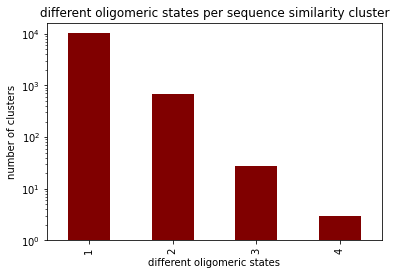

In [ ]:
from typing import Text
print(overall_train_set_no_embed.groupby("representative").nunique("nsub").groupby("nsub").size(), "different nsubs in cluster")
overall_train_set_no_embed.groupby("representative").nunique("nsub").groupby("nsub").size().plot(kind='bar', grid=False, log=True, color="maroon", fontsize=10, title="different oligomeric states per sequence similarity cluster", xlabel="different oligomeric states", ylabel="number of clusters")


code
1      6929
2      1689
3       761
4       408
5       242
       ... 
153       1
194       1
218       1
240       1
242       1
Length: 74, dtype: int64 number of different pdb in each cluster


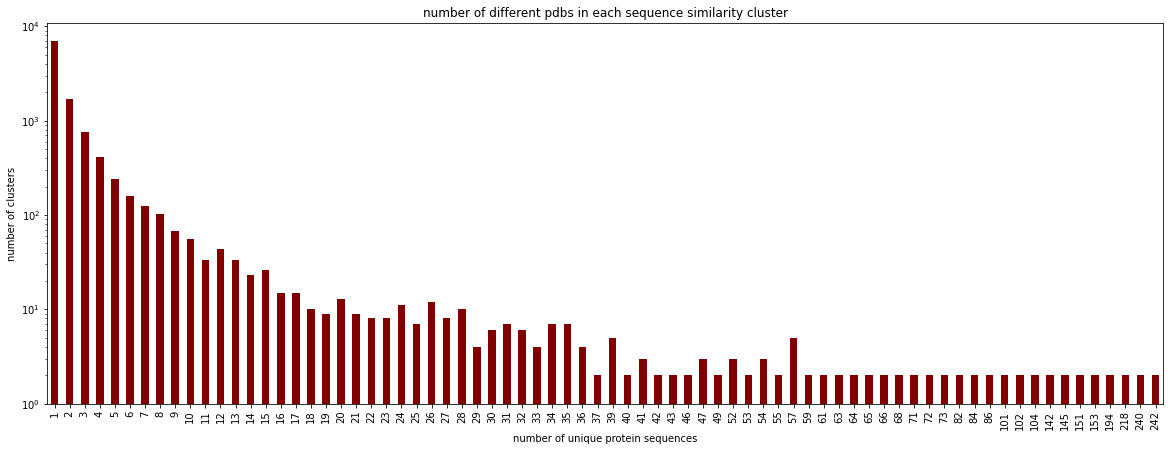

In [ ]:
print(overall_train_set_no_embed.groupby("representative").nunique("code").groupby("code").size(), "number of different pdb in each cluster")
overall_train_set_no_embed.groupby("representative").nunique("code").groupby("code").size().plot(kind='bar', color="maroon", figsize=[20,7], fontsize=10, log=True, grid=False, title="number of different pdbs in each sequence similarity cluster", xlabel="number of unique protein sequences", ylabel="number of clusters")

In [ ]:
# ##################################
# # # opened the xgb_model in ipython and obtained the stats (since it crashes here)
# # # the code:
# xgb_joblib = joblib.load("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/results_072022/xgb_joblib8020.joblib")

# with open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/results_072022/X_train_80.pkl", 'rb') as f:
#     X_train = pickle.load(f)
# with open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/results_072022/y_train_80.pkl", 'rb') as f:
#     y_train = pickle.load(f)
# with open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/results_072022/X_test_20.pkl", 'rb') as f:
#     X_test = pickle.load(f)
# with open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/results_072022/y_test_20.pkl", 'rb') as f:
#     y_test = pickle.load(f)

# y_train = y_train.values.astype(int)
# y_test = y_test.values.astype(int)
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

# y_pred = xgb_joblib.predict(X_test)
# print("adjusted Balanced accuracy:", metrics.balanced_accuracy_score(y_test, y_pred, adjusted=True))
# # print("roc_auc_score:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovr'))
# # print("PR:", metrics.precision_recall_fscore_support(y_test,y_pred))
# print('Precision: %.3f' % precision_score(y_test, y_pred, average='weighted'))
# print('Recall: %.3f' % recall_score(y_test, y_pred, average='weighted'))
# print('F-measure: %.3f' % f1_score(y_test, y_pred, average='weighted'))
# print(metrics.classification_report(y_test,y_pred))
# print(metrics.confusion_matrix(y_test,y_pred))
# class_report = metrics.classification_report(y_test,y_pred, output_dict=True)
# conf_mat = metrics.confusion_matrix(y_test,y_pred)
# conf_mat_df = pd.DataFrame(conf_mat)

# res = {}
# for cl in le.classes_:
#     res.update({cl:le.transform([cl])[0]})
# inv_map = {v: k for k, v in res.items()}

# conf_mat_df.rename(inv_map, axis=1, inplace=True)
# conf_mat_df.rename(inv_map, inplace=True)

# pickle.dump(conf_mat_df, open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/conf_mat_df_14072022.pkl", "wb"))

# class_report_df = pd.DataFrame(class_report).transpose()
# class_report_df.index = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 24, "accuracy", "macro_avg", "weighted_avg"]
# pickle.dump(class_report_df, open("/vol/ek/Home/orlyl02/working_dir/oligopred/xgboost/class_report_df_14072022.pkl", "wb"))

# # ##################################

In [ ]:
with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/conf_mat_df_14072022.pkl", 'rb') as f:
  conf_mat_df = pickle.load(f)

with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/class_report_df_14072022.pkl", 'rb') as f:
  class_report_df = pickle.load(f)

In [ ]:
conf_mat_df

,1,2,3,4,5,6,7,8,10,12,14,24
1,2038,490,7,10,1,5,0,0,0,0,0,0
2,581,1100,3,67,0,9,0,1,0,0,0,0
3,31,130,78,19,0,19,0,0,0,1,0,0
4,71,249,38,353,0,4,0,0,0,0,0,0
5,3,10,0,1,28,1,0,0,0,0,0,0
6,15,69,2,33,0,12,0,0,0,0,0,0
7,1,4,0,0,0,0,0,0,0,0,0,0
8,6,34,0,39,0,1,0,13,0,0,0,0
10,3,37,0,15,0,3,0,0,0,0,0,0
12,1,18,0,12,0,0,0,0,0,2,0,0


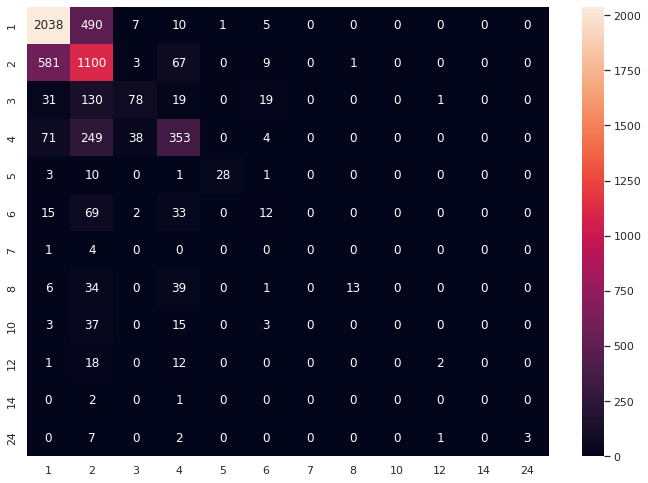

In [ ]:
from matplotlib import figure
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(conf_mat_df, annot=True, fmt='g')

In [ ]:
class_report_df = class_report_df.round(3)

In [ ]:
class_report_df

,precision,recall,f1-score,support
1,0.741,0.799,0.769,2551.000
2,0.512,0.625,0.563,1761.000
3,0.609,0.281,0.384,278.000
4,0.639,0.494,0.557,715.000
5,0.966,0.651,0.778,43.000
6,0.222,0.092,0.130,131.000
7,0.000,0.000,0.000,5.000
8,0.929,0.140,0.243,93.000
10,0.000,0.000,0.000,58.000
12,0.500,0.061,0.108,33.000


In [ ]:
conf_mat_df

,1,2,3,4,5,6,7,8,10,12,14,24
1,2038,490,7,10,1,5,0,0,0,0,0,0
2,581,1100,3,67,0,9,0,1,0,0,0,0
3,31,130,78,19,0,19,0,0,0,1,0,0
4,71,249,38,353,0,4,0,0,0,0,0,0
5,3,10,0,1,28,1,0,0,0,0,0,0
6,15,69,2,33,0,12,0,0,0,0,0,0
7,1,4,0,0,0,0,0,0,0,0,0,0
8,6,34,0,39,0,1,0,13,0,0,0,0
10,3,37,0,15,0,3,0,0,0,0,0,0
12,1,18,0,12,0,0,0,0,0,2,0,0


[Text(81.8, 0.5, 'Actual lables'), Text(0.5, 50.92999999999999, 'Prediction')]

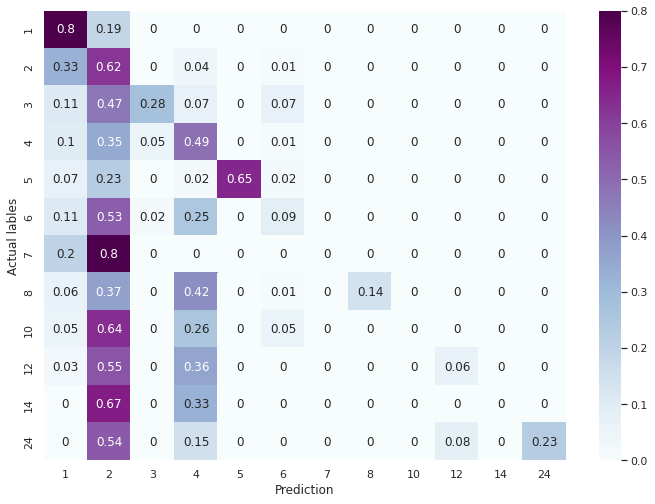

In [ ]:
conf_mat_df_percent = conf_mat_df.div(conf_mat_df.sum(axis=1), axis=0).round(2)
s = sns.heatmap(conf_mat_df_percent, annot=True, fmt='g', cmap="BuPu")
s.set(xlabel='Prediction', ylabel='Actual lables')

In [ ]:
conf_mat_df.sum(axis=1).to_dict()

{1: 2551,
 2: 1761,
 3: 278,
 4: 715,
 5: 43,
 6: 131,
 7: 5,
 8: 93,
 10: 58,
 12: 33,
 14: 3,
 24: 13}

In [ ]:
# # Calc the percent of each group
# # add the diagonal
# # normalize the two

# res = {}
# for cl in le.classes_:
#     res.update({cl:le.transform([cl])[0]})
# inv_map = {v: k for k, v in res.items()}


# conf_mat_percent_diagonal = np.diag(conf_mat_df_percent)
# conf_mat_percent_diagonal = pd.Series(np.diag(conf_mat_df_percent))
# conf_mat_percent_diagonal = pd.DataFrame(conf_mat_percent_diagonal)
# conf_mat_percent_diagonal.rename(index=inv_map, inplace=True)
# conf_mat_percent_diagonal.rename(columns={0: "diagonal"}, inplace=True)

# for k, v in pdbs_nsub_dict.items():
#     pdbs_nsub_dict[k] = round(v/conf_mat_df.sum(axis=1).sum(), 3)
# pdbs_nsub_dict_df = pd.DataFrame.from_dict(pdbs_nsub_dict, orient='index')
# pdbs_nsub_dict_df.rename(columns={0: "percent_of_entries"}, inplace=True)

# normalized_from_conf_mat = pd.concat((conf_mat_percent_diagonal, pdbs_nsub_dict_df), axis=1)
# normalized_from_conf_mat["normalized"] = normalized_from_conf_mat["percent_of_entries"]/normalized_from_conf_mat["diagonal"]
# normalized_from_conf_mat["normalized"] = normalized_from_conf_mat["normalized"].round(3)


NameError: ignored

In [ ]:
rep_more_than_one_sequence_per_clust = overall_train_set_no_embed.groupby("representative")["code"].count()>1

In [ ]:
rep_more_than_one_sequence_per_clust_list = rep_more_than_one_sequence_per_clust[rep_more_than_one_sequence_per_clust].index.tolist()

In [ ]:
rep_class = overall_train_set_no_embed.groupby("representative")["nsub"].agg(lambda x:x.value_counts().index[0])

In [ ]:
rep_class = rep_class.reset_index()

In [ ]:
rep_class.rename(columns = {'nsub':'predict_nsub_from_rep'}, inplace = True)

In [ ]:
rep_class

,representative,predict_nsub_from_rep
0,11as_1,2.0
1,155c_1,1.0
2,16pk_1,1.0
3,16vp_1,1.0
4,1914_1,1.0
...,...,...
10889,5xb0_1,1.0
10890,5xdr_1,1.0
10891,5xgf_1,2.0
10892,6abp_1,1.0


In [ ]:
train_set_rep_prediction = overall_train_set_no_embed.merge(rep_class, on="representative", how="left")
train_set_rep_prediction = train_set_rep_prediction[train_set_rep_prediction.representative.isin(rep_more_than_one_sequence_per_clust_list)]

In [ ]:
train_set_rep_prediction_subset = train_set_rep_prediction[["nsub", "predict_nsub_from_rep"]]
train_set_rep_prediction_subset.reset_index(drop=True, inplace=True)
train_set_rep_prediction_subset

,nsub,predict_nsub_from_rep
0,3.0,3.0
1,6.0,6.0
2,4.0,4.0
3,4.0,4.0
4,4.0,4.0
...,...,...
21894,2.0,2.0
21895,2.0,2.0
21896,2.0,2.0
21897,2.0,2.0


In [ ]:
confusion_matrix_rep = pd.crosstab(train_set_rep_prediction_subset['nsub'].astype(int), train_set_rep_prediction_subset['predict_nsub_from_rep'].astype(int), rownames=['Actual'], colnames=['Predicted'] )


In [ ]:
confusion_matrix_rep

Predicted,1,2,3,4,5,6,7,8,9,10,12,14,16,24
Actual,,,,,,,,,,,,,,
1,9945,244,1,27,0,5,1,3,0,0,1,0,0,0
2,707,6092,6,136,1,17,0,6,0,4,2,0,1,0
3,8,8,911,2,0,6,0,0,0,0,0,0,0,2
4,21,86,0,2245,0,4,0,1,0,0,0,0,0,0
5,0,0,0,0,104,0,0,0,0,0,0,0,0,0
6,2,14,29,1,1,600,0,2,0,0,0,0,0,0
7,0,0,0,0,0,0,13,0,0,0,0,0,0,0
8,2,13,0,15,0,0,0,218,0,1,0,0,1,0
9,0,0,0,0,0,0,0,0,3,0,0,0,0,0


In [ ]:
confusion_matrix_rep_percent = confusion_matrix_rep.div(confusion_matrix_rep.sum(axis=1), axis=0).round(2)

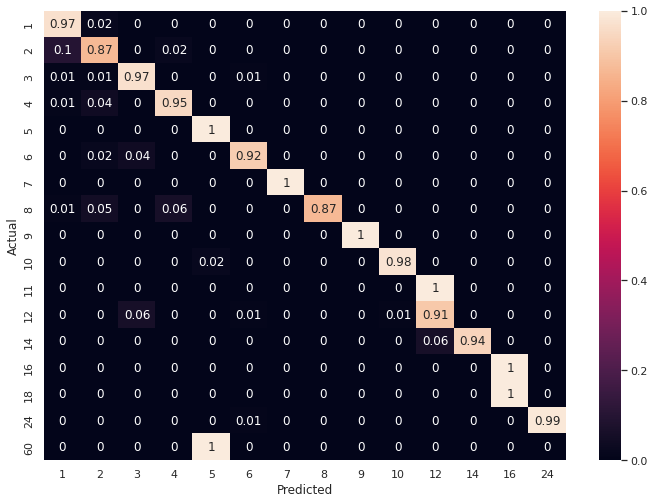

In [ ]:
sns.heatmap(confusion_matrix_rep_percent, annot=True, fmt='g')

In [ ]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify   


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


18 - number of different oligomeric assemblies
nsub
1.0     13463
2.0      9892
4.0      2643
3.0      1177
6.0       777
8.0       292
12.0      168
5.0       127
24.0      120
10.0       95
14.0       37
7.0        20
9.0         5
16.0        5
60.0        4
11.0        1
13.0        1
18.0        1
dtype: int64


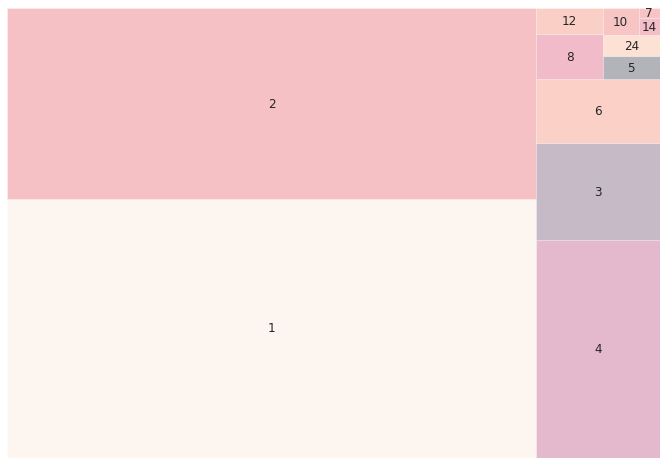

In [ ]:
print(overall_train_set_no_embed.groupby("nsub").size().count(), "- number of different oligomeric assemblies")
print(overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False))
# overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False).plot(kind='bar', grid=False, log=True, color="maroon", fontsize=10, title="number of pdbs per oligomeric state", xlabel="oligomeric state", ylabel="number of unique protein sequences")
nsub_count = overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False).transpose()
nsub_count = nsub_count[nsub_count >5]
labels = nsub_count.index.astype(int).tolist()
sizes = nsub_count.tolist()
# squarify.plot(sizes=sizes,alpha=.5)
squarify.plot(sizes=sizes, label=labels, alpha=.3)

plt.axis('off')
plt.show()


# overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False).plot(kind='donut', autopct='%1.1f%%', startangle=270, fontsize=10, title="number of pdbs per oligomeric state", xlabel="oligomeric state", ylabel="number of unique protein sequences")

In [ ]:
nsub_count[nsub_count >5]

nsub
1.0     13463
2.0      9892
4.0      2643
3.0      1177
6.0       777
8.0       292
12.0      168
5.0       127
24.0      120
10.0       95
14.0       37
7.0        20
dtype: int64

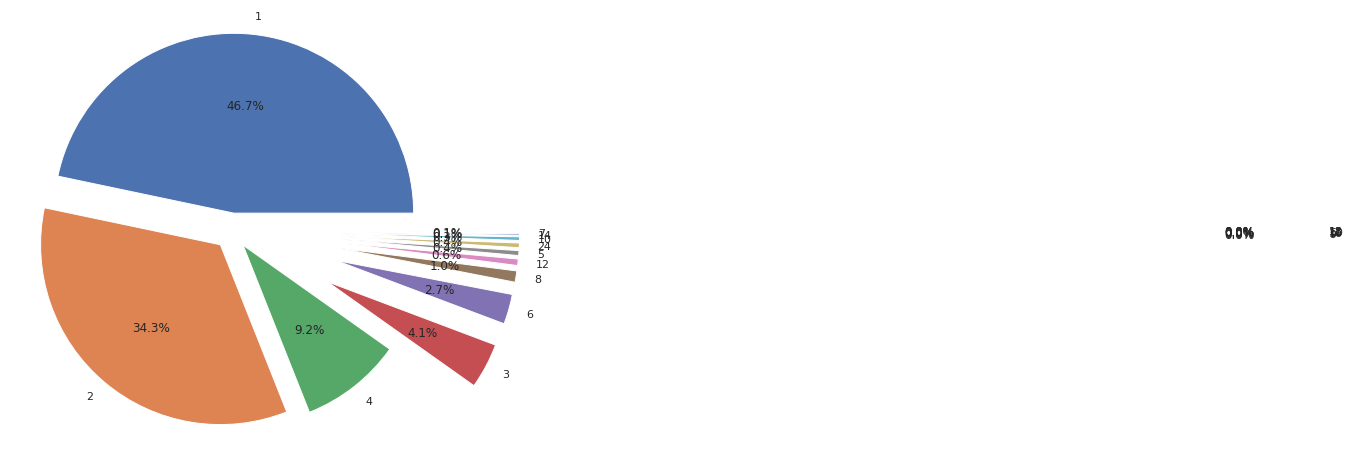

In [ ]:
distance = 0.2
separate = (distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance, distance)
a = overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False)
nsub_count = overall_train_set_no_embed.groupby("nsub").size().sort_values(ascending=False).transpose()
labels = nsub_count.index.astype(int).tolist()
sizes = nsub_count.tolist()

# # Illustration 1
distance1 = 0.1
distance2 = 0.6
distance3 = 5
separate = (distance1, distance1, distance1, distance2, distance2, distance2, distance2, distance2, distance2, distance2, distance2, distance2, distance3, distance3, distance3, distance3, distance3, distance3)
plt.figure()
p = plt.pie(sizes,labels=labels, explode=separate, autopct='%1.1f%%')


In [ ]:
list_of_nsubs = list(set(train_set_rep_prediction["nsub"].tolist()))
print("nsub", "num_of_clusts", "num_of_codes")
for nsub in list_of_nsubs:
  num_of_clusts = overall_train_set_no_embed[overall_train_set_no_embed['nsub'] == nsub].groupby("representative").nunique().shape[0]
  print(nsub, num_of_clusts, overall_train_set_no_embed.groupby("nsub").size()[nsub])


nsub num_of_clusts num_of_codes
1.0 5248 13463
2.0 4747 9892
3.0 442 1177
4.0 642 2643
5.0 42 127
6.0 292 777
7.0 11 20
8.0 100 292
9.0 3 5
10.0 28 95
11.0 1 1
12.0 60 168
14.0 9 37
16.0 1 5
18.0 1 1
24.0 18 120
60.0 1 4


In [ ]:
overall_train_set_no_embed.groupby(["representative", "nsub"])["code"].count()

representative  nsub
11as_1          2.0      2
155c_1          1.0      4
16pk_1          1.0     23
                2.0      2
16vp_1          1.0      1
                        ..
5xb0_1          1.0      1
5xdr_1          1.0      2
5xgf_1          2.0      2
6abp_1          1.0      3
6rxn_1          1.0      1
Name: code, Length: 11647, dtype: int64

In [ ]:
with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/y_prob20072022.pkl", 'rb') as f:
  y_prob = pickle.load(f)

In [ ]:
y_prob_df = pd.DataFrame(y_prob)
inv_map = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 10, 9: 12, 10: 14, 11: 24}
y_prob_df.rename(columns=inv_map, inplace=True)

In [ ]:
y_prob_df.max(axis=1).median()
y_prob_df.apply(lambda x: x.nlargest(3).values, axis=1, result_type='expand').describe()

,0,1,2
count,5684.000000,5684.000000,5.684000e+03
mean,0.848950,0.121970,1.755182e-02
std,0.167140,0.135566,3.833301e-02
min,0.280435,0.000001,2.713958e-08
25%,0.739496,0.008088,1.302437e-04
50%,0.918782,0.064593,1.470399e-03
75%,0.989597,0.208648,1.251306e-02
max,0.999999,0.498676,3.180263e-01


In [ ]:
y_prob_df.apply(lambda x: x.nlargest(3).index, axis=1, result_type='expand')

,0,1,2
0,2,4,1
1,2,1,4
2,1,2,5
3,4,2,1
4,4,2,1
...,...,...,...
5679,1,2,5
5680,1,2,3
5681,2,1,4
5682,2,1,6


In [ ]:
with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/y_test_20.pkl", 'rb') as f:
  y_test = pickle.load(f)

In [ ]:
y_test.reset_index()

,index,nsub
0,10,4.0
1,13,4.0
2,16,4.0
3,26,4.0
4,27,4.0
...,...,...
5679,28768,2.0
5680,28771,2.0
5681,28772,2.0
5682,28784,2.0


In [ ]:
y_prob_df

,1,2,3,4,5,6,7,8,10,12,14,24
0,0.034544,0.922939,0.000151,4.107983e-02,0.000067,3.060632e-05,3.603091e-05,3.722725e-04,1.669654e-04,5.027475e-04,7.413496e-05,3.676073e-05
1,0.000553,0.999265,0.000004,1.256785e-04,0.000004,3.982684e-06,1.833959e-05,3.049169e-06,1.245950e-05,4.107635e-06,3.826845e-06,2.967774e-06
2,0.991830,0.008140,0.000005,4.494132e-06,0.000012,7.241321e-07,8.303435e-07,3.045704e-07,2.651988e-06,3.222708e-07,1.425031e-06,1.773081e-06
3,0.027123,0.087447,0.000027,8.852548e-01,0.000008,2.312159e-05,2.156526e-05,6.770580e-06,8.154978e-06,7.099013e-06,2.505702e-05,4.881084e-05
4,0.000689,0.002984,0.000005,9.963139e-01,0.000002,1.146097e-06,1.248567e-06,1.679925e-07,8.301395e-07,5.970080e-07,1.061730e-06,2.271228e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
5679,0.994096,0.005813,0.000025,1.023373e-05,0.000039,1.006654e-06,2.447093e-06,1.255604e-06,4.075100e-06,3.534943e-07,3.934819e-06,3.472194e-06
5680,0.999631,0.000354,0.000005,4.916363e-07,0.000002,2.495749e-06,1.730329e-06,4.156378e-07,4.877024e-07,1.895969e-07,5.770978e-07,2.855196e-07
5681,0.147044,0.848993,0.000573,1.411541e-03,0.000058,1.349464e-03,1.993904e-04,2.897973e-05,1.065010e-04,2.906132e-05,5.761927e-05,1.490415e-04
5682,0.000295,0.999414,0.000004,4.377236e-05,0.000010,8.155642e-05,2.912308e-05,6.947063e-05,8.607221e-06,2.162512e-05,6.517738e-06,1.588721e-05


In [ ]:
proba_pred_actual = pd.concat((y_prob_df.apply(lambda x: x.nlargest(3).index, axis=1, result_type='expand'), y_test.reset_index().nsub.astype(int)), axis=1)
proba_pred_actual

,0,1,2,nsub
0,2,4,1,4
1,2,1,4,4
2,1,2,5,4
3,4,2,1,4
4,4,2,1,4
...,...,...,...,...
5679,1,2,5,2
5680,1,2,3,2
5681,2,1,4,2
5682,2,1,6,2


In [ ]:
print(proba_pred_actual[0].eq(proba_pred_actual['nsub']).sum())
print(proba_pred_actual[1].eq(proba_pred_actual['nsub']).sum())
print(proba_pred_actual[2].eq(proba_pred_actual['nsub']).sum())


3627
1354
288


In [ ]:
# choose from the top 2 predictions to improve recall 
proba_pred_actual['top_2'] = np.where(proba_pred_actual[1] == proba_pred_actual["nsub"],proba_pred_actual[1], proba_pred_actual[0])
# np.where(condition, value if condition is true, value if condition is false)


In [ ]:
proba_pred_actual

,0,1,2,nsub,top_2
0,2,4,1,4,4
1,2,1,4,4,2
2,1,2,5,4,1
3,4,2,1,4,4
4,4,2,1,4,4
...,...,...,...,...,...
5679,1,2,5,2,2
5680,1,2,3,2,2
5681,2,1,4,2,2
5682,2,1,6,2,2


[Text(81.8, 0.5, 'Actual lables'), Text(0.5, 50.92999999999999, 'Prediction')]

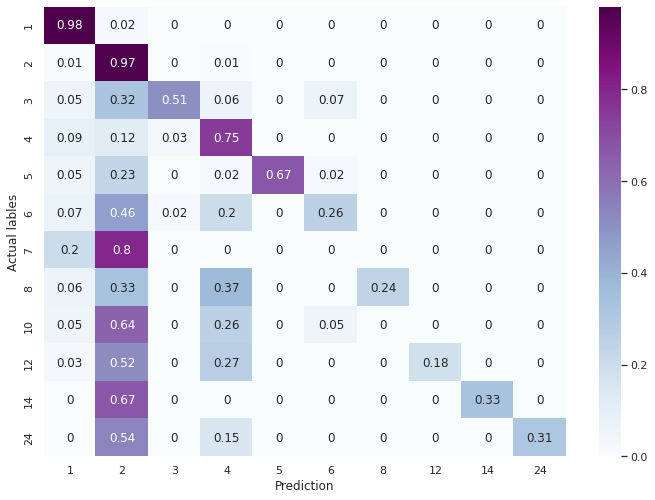

In [ ]:
confusion_matrix_top2 = pd.crosstab(proba_pred_actual['nsub'].astype(int), proba_pred_actual['top_2'].astype(int), rownames=['Actual'], colnames=['Predicted'] )
confusion_matrix_top2_percent = confusion_matrix_top2.div(confusion_matrix_top2.sum(axis=1), axis=0).round(2)
s = sns.heatmap(confusion_matrix_top2_percent, annot=True, fmt='g', cmap="BuPu")
s.set(xlabel='Prediction', ylabel='Actual lables')

In [ ]:
y_prob_df_with_true_labels = pd.concat((y_prob_df, y_test.reset_index().nsub.astype(int)), axis=1)

In [ ]:
dimers = y_prob_df_with_true_labels[y_prob_df_with_true_labels["nsub"] == 2]
dimers[2].describe()

count    1761.000000
mean        0.595362
std         0.378237
min         0.000015
25%         0.207176
50%         0.727841
75%         0.960431
max         0.999995
Name: 2, dtype: float64

In [ ]:
y_prob_df_with_true_labels[[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 24]].max(axis=1)

0       0.922939
1       0.999265
2       0.991830
3       0.885255
4       0.996314
          ...   
5679    0.994096
5680    0.999631
5681    0.848993
5682    0.999414
5683    0.961689
Length: 5684, dtype: float32

In [ ]:
# subset of df where we predict a dimer
dimer_pred = y_prob_df_with_true_labels[y_prob_df_with_true_labels[[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 24]].idxmax(axis=1) == 2]
dimer_pred_not_dimers = dimer_pred[dimer_pred.nsub !=2]
dimer_pred_dimers = dimer_pred[dimer_pred.nsub ==2]

count    1050.000000
mean        0.775785
std         0.173722
min         0.303096
25%         0.636069
50%         0.806042
75%         0.933912
max         0.999625
Name: 2, dtype: float64


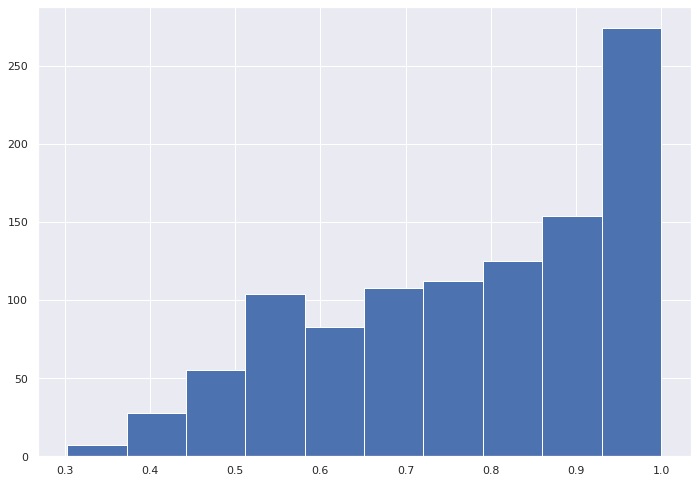

In [ ]:
print(dimer_pred_not_dimers[2].describe())
dimer_pred_not_dimers[2].hist()

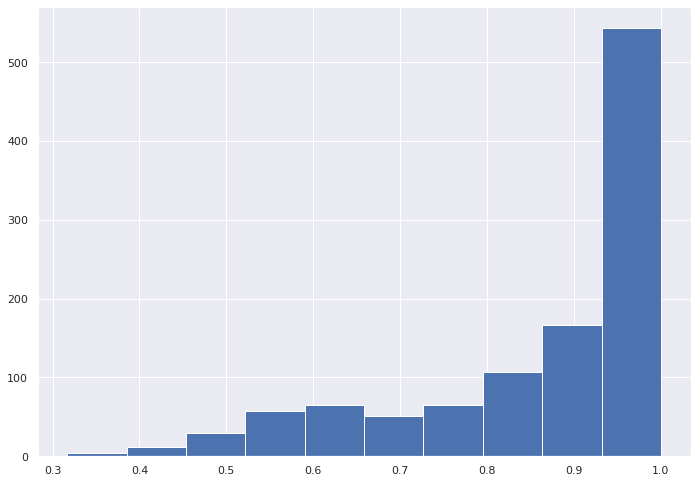

In [ ]:
dimer_pred_dimers[2].describe()
dimer_pred_dimers[2].hist()

In [ ]:
y_prob_df_with_true_labels

,1,2,3,4,5,6,7,8,10,12,14,24,nsub
0,0.034544,0.922939,0.000151,4.107983e-02,0.000067,3.060632e-05,3.603091e-05,3.722725e-04,1.669654e-04,5.027475e-04,7.413496e-05,3.676073e-05,4
1,0.000553,0.999265,0.000004,1.256785e-04,0.000004,3.982684e-06,1.833959e-05,3.049169e-06,1.245950e-05,4.107635e-06,3.826845e-06,2.967774e-06,4
2,0.991830,0.008140,0.000005,4.494132e-06,0.000012,7.241321e-07,8.303435e-07,3.045704e-07,2.651988e-06,3.222708e-07,1.425031e-06,1.773081e-06,4
3,0.027123,0.087447,0.000027,8.852548e-01,0.000008,2.312159e-05,2.156526e-05,6.770580e-06,8.154978e-06,7.099013e-06,2.505702e-05,4.881084e-05,4
4,0.000689,0.002984,0.000005,9.963139e-01,0.000002,1.146097e-06,1.248567e-06,1.679925e-07,8.301395e-07,5.970080e-07,1.061730e-06,2.271228e-06,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,0.994096,0.005813,0.000025,1.023373e-05,0.000039,1.006654e-06,2.447093e-06,1.255604e-06,4.075100e-06,3.534943e-07,3.934819e-06,3.472194e-06,2
5680,0.999631,0.000354,0.000005,4.916363e-07,0.000002,2.495749e-06,1.730329e-06,4.156378e-07,4.877024e-07,1.895969e-07,5.770978e-07,2.855196e-07,2
5681,0.147044,0.848993,0.000573,1.411541e-03,0.000058,1.349464e-03,1.993904e-04,2.897973e-05,1.065010e-04,2.906132e-05,5.761927e-05,1.490415e-04,2
5682,0.000295,0.999414,0.000004,4.377236e-05,0.000010,8.155642e-05,2.912308e-05,6.947063e-05,8.607221e-06,2.162512e-05,6.517738e-06,1.588721e-05,2


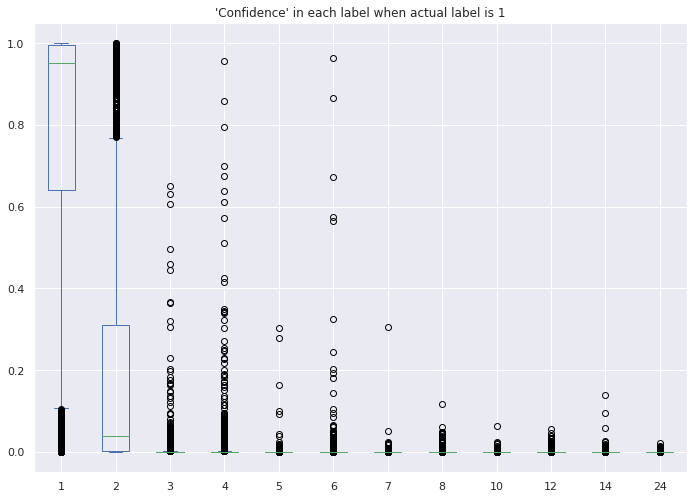

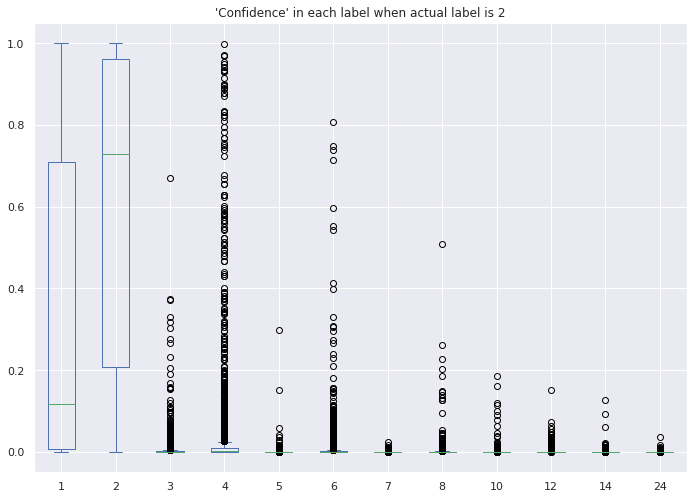

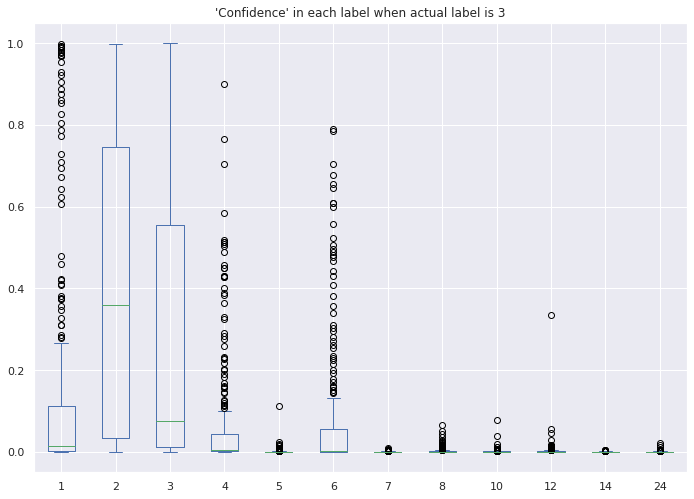

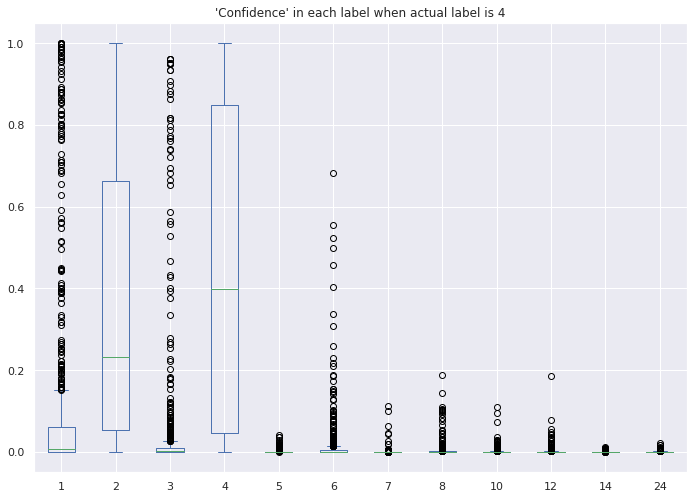

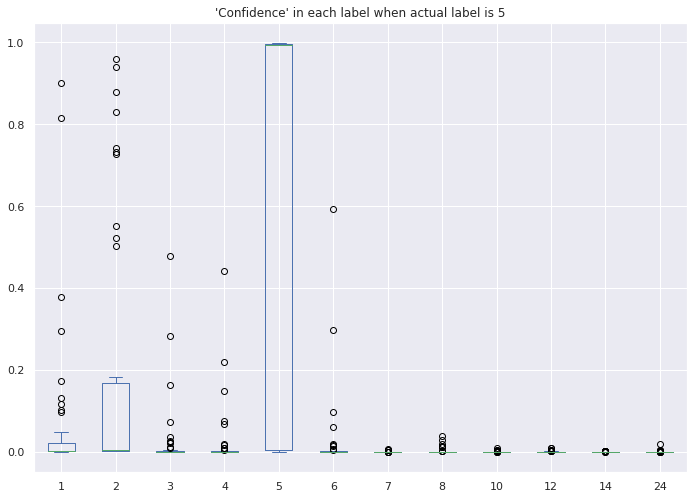

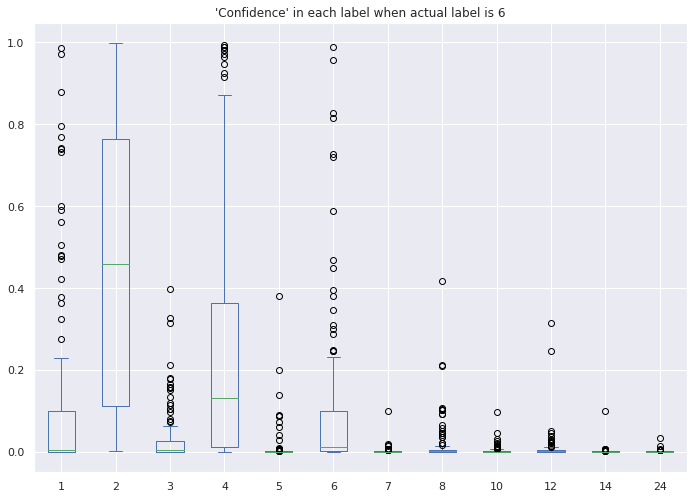

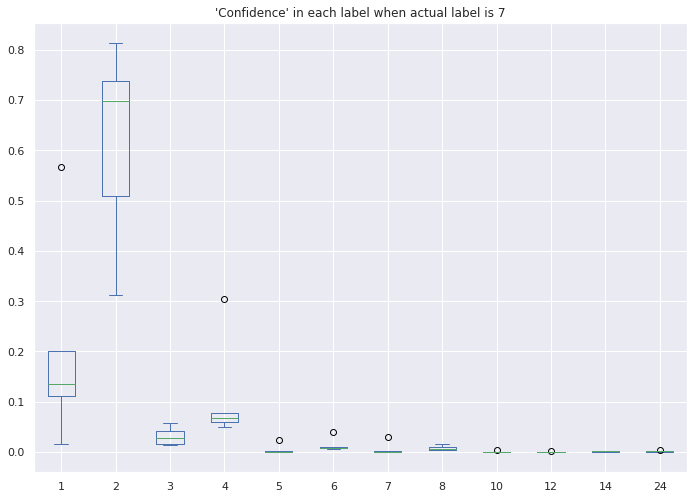

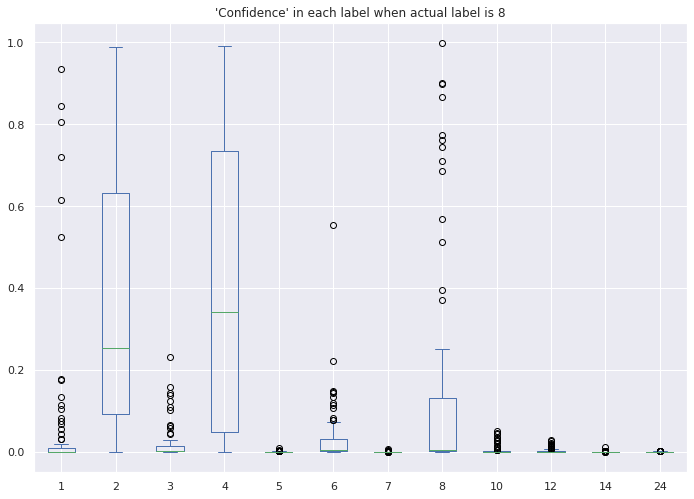

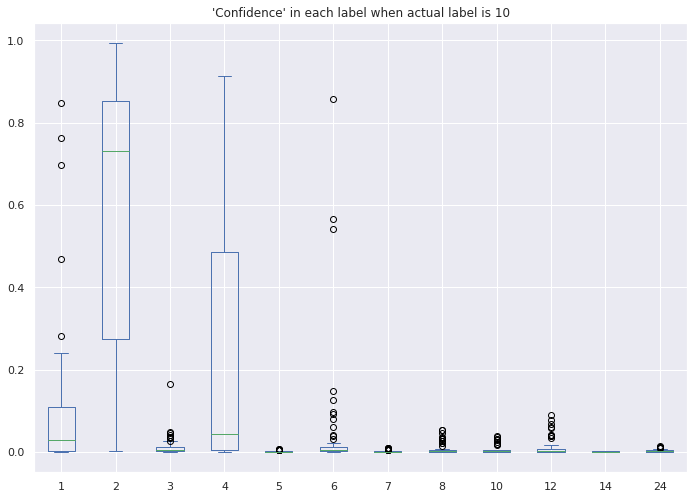

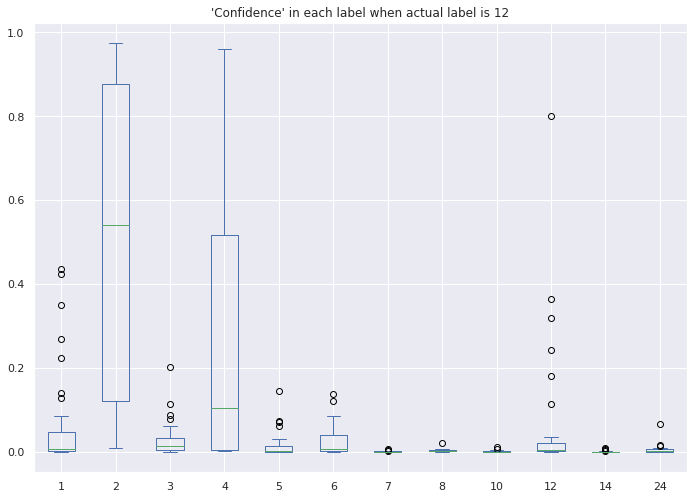

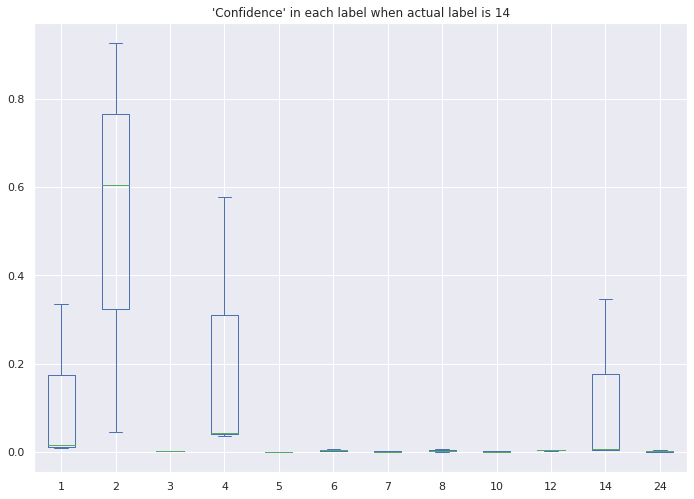

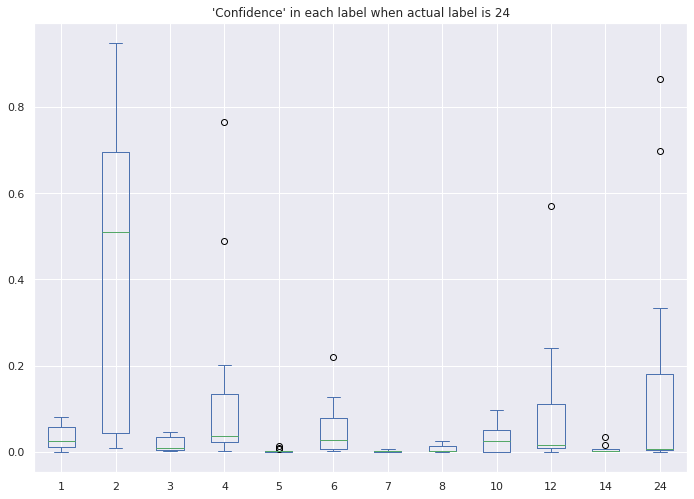

In [ ]:
for chosen_nsub in sorted(y_prob_df_with_true_labels.nsub.unique().tolist()):
  chosen_df = y_prob_df_with_true_labels[y_prob_df_with_true_labels.nsub == chosen_nsub][[1,2,3,4,5,6,7,8,10,12,14,24]]
  chosen_df.plot.box(title="'Confidence' in each label when actual label is " + str(chosen_nsub))

# only for highest softmax value


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
features = [1,2,3,4,5,6,7,8,10,12,14,24]
clf = LogisticRegressionCV(random_state=0, cv=10, solver="liblinear").fit(y_prob_df_with_true_labels[features], y_prob_df_with_true_labels.nsub)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  UserWarning,


In [ ]:
y_test

10       4.0
13       4.0
16       4.0
26       4.0
27       4.0
        ... 
28768    2.0
28771    2.0
28772    2.0
28784    2.0
28806    2.0
Name: nsub, Length: 5684, dtype: float64

In [ ]:
with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/y_pred_inverted_24072022.pkl", 'rb') as f:
  y_pred_inv = pickle.load(f)

In [ ]:
y_pred_inv_df = pd.DataFrame(y_pred_inv)

In [ ]:
y_pred_actual = pd.concat((y_pred_inv_df, y_test.reset_index().nsub.astype(int)), axis=1)
# y_pred_probapred = pd.concat((y_prob_df.apply(lambda x: x.nlargest(1).index, axis=1, result_type='expand'), y_pred_inv_df), axis=1)
# proba_pred_actual = pd.concat((y_prob_df.apply(lambda x: x.nlargest(3).index, axis=1, result_type='expand'), y_test.reset_index().nsub.astype(int)), axis=1)


In [ ]:
# make sure that the chosen final prediction from the model is indeed the max
y_pred_inv_df[0].equals(proba_pred_actual[0])

True

In [ ]:
y_prob_df_with_true_labels_2_08 = y_prob_df_with_true_labels.copy()
y_prob_df_with_true_labels_2_08[2] = np.where(y_prob_df_with_true_labels[2]<0.8, 0,y_prob_df_with_true_labels[2])


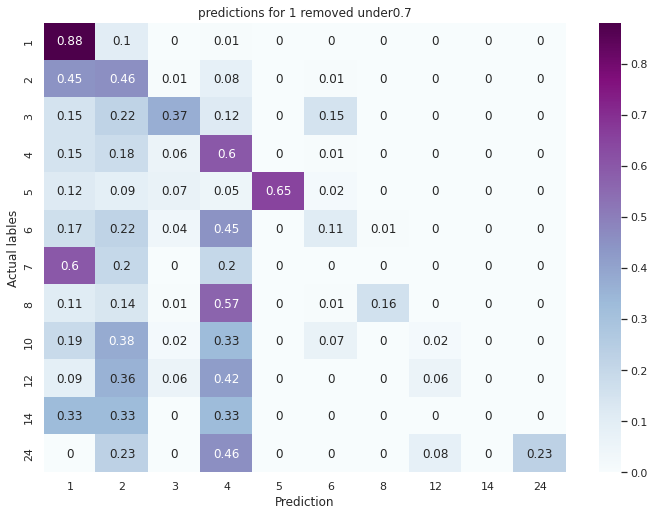

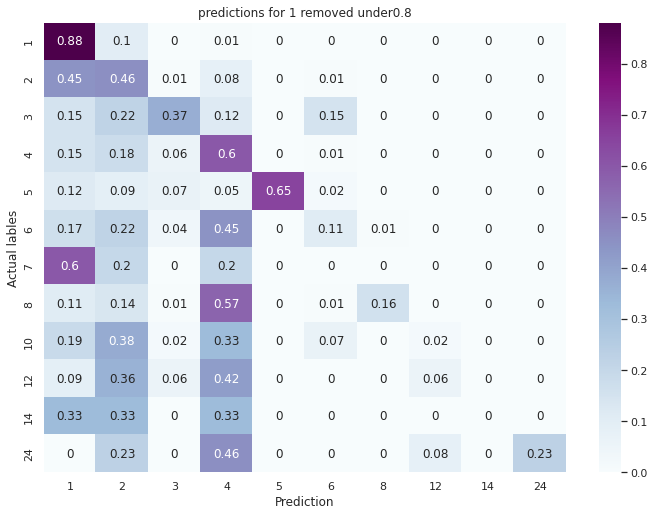

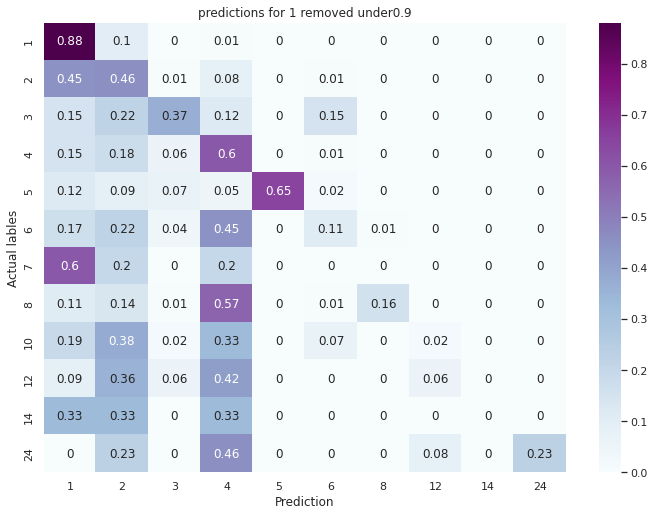

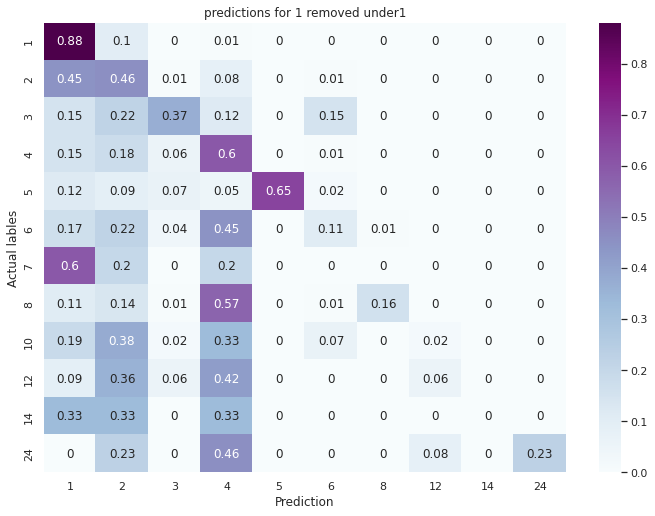

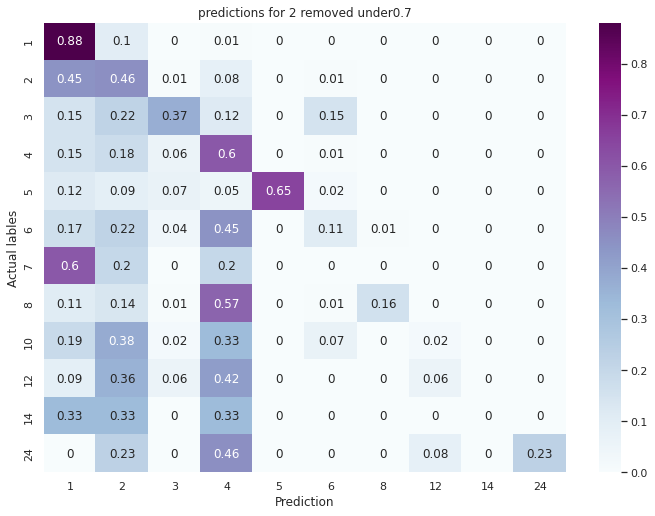

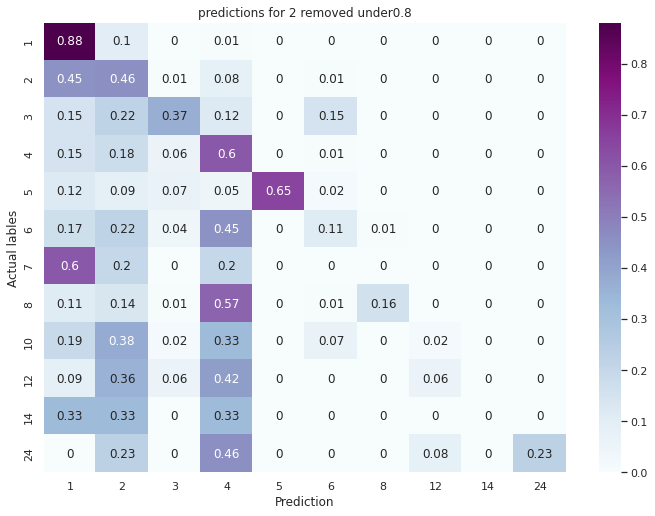

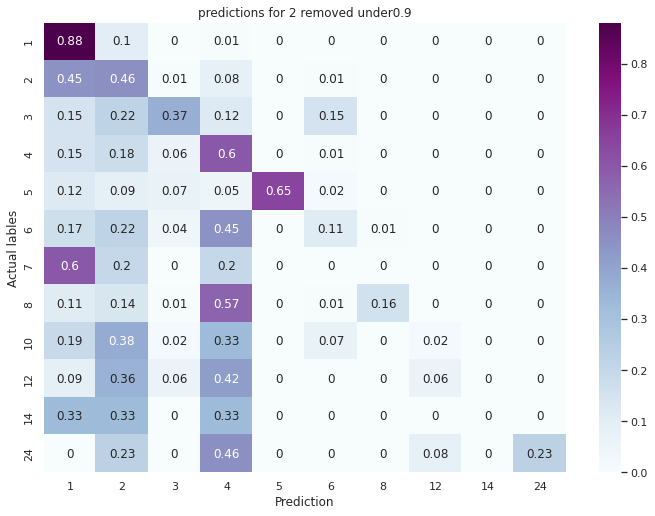

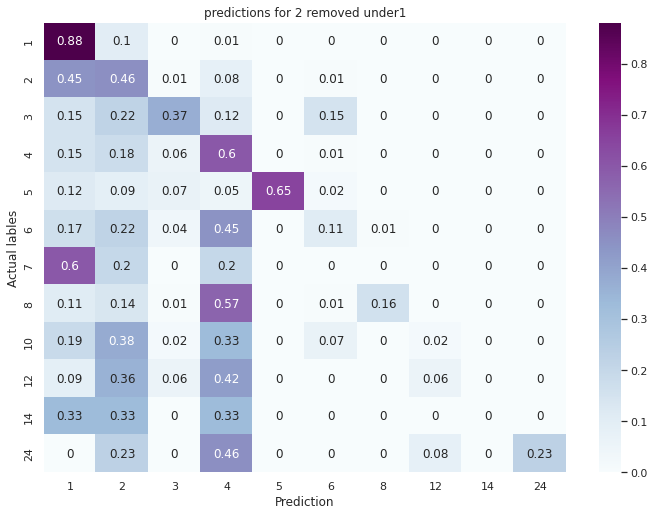

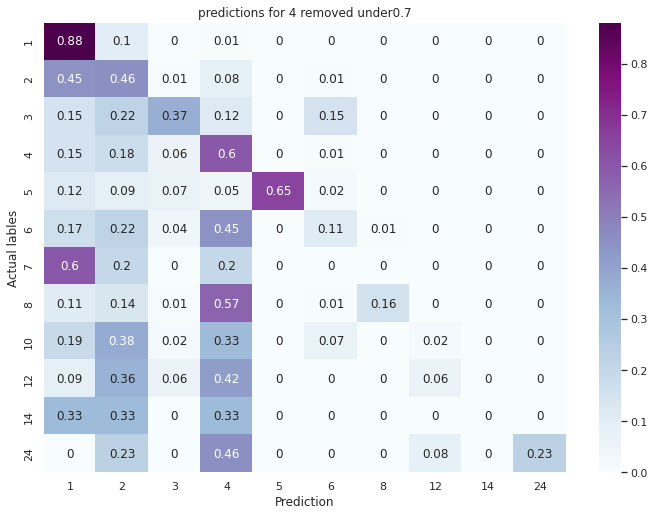

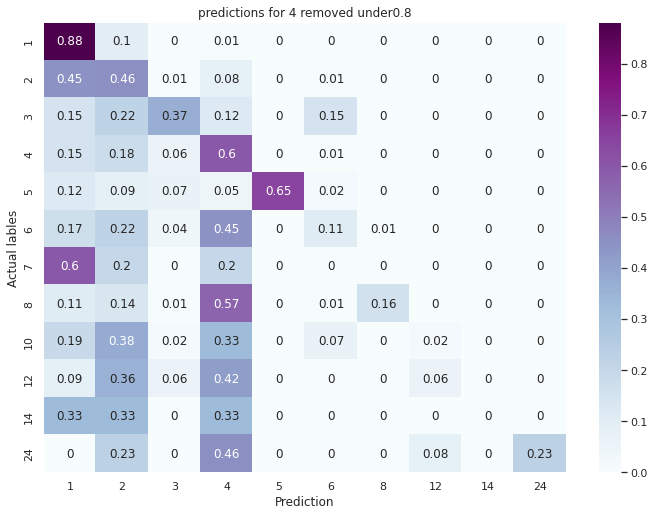

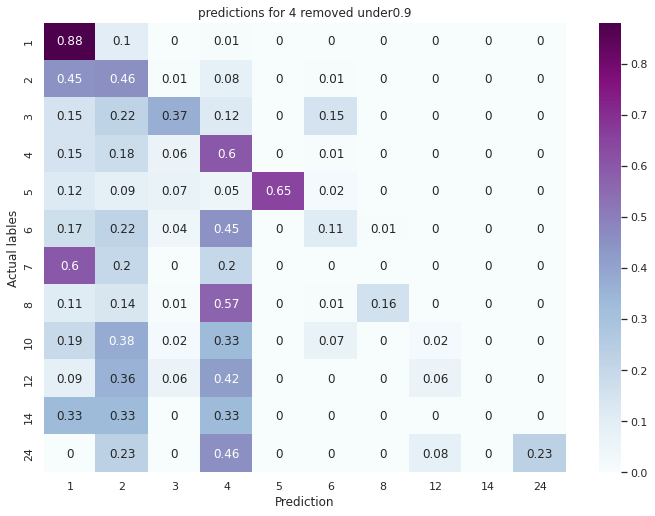

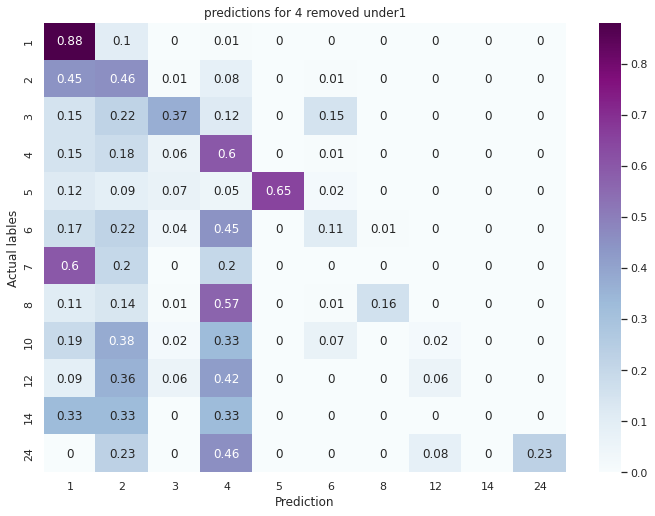

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:
#just to get an intuition of the data


qs_list = [1,2,4]
cutoff_list = [0.7,0.8,0.9,1]
y_prob_df_with_true_labels_checks = y_prob_df_with_true_labels.copy()
for qs in qs_list:
  for cutoff in cutoff_list:
    y_prob_df_with_true_labels_checks[qs] = np.where(y_prob_df_with_true_labels[qs]<cutoff, 0,y_prob_df_with_true_labels[qs])
    confusion_matrix_2_08 = pd.crosstab(proba_pred_actual['nsub'].astype(int), y_prob_df_with_true_labels_2_08[features].idxmax(axis=1).astype(int), rownames=['Actual'], colnames=['Predicted'] )
    confusion_matrix_2_08_percent = confusion_matrix_2_08.div(confusion_matrix_2_08.sum(axis=1), axis=0).round(2)
    s = sns.heatmap(confusion_matrix_2_08_percent, annot=True, fmt='g', cmap="BuPu")
    plt.figure()
    s.set(xlabel='Prediction', ylabel='Actual lables', title="predictions for " + str(qs) + " removed under" + str(cutoff))


# It seems 

[Text(81.8, 0.5, 'Actual lables'), Text(0.5, 50.92999999999999, 'Prediction')]

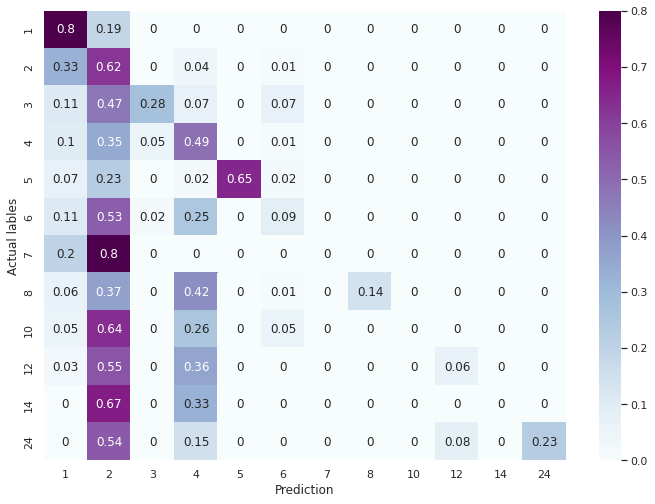

In [ ]:
# This is the original confusion matrix, it is here just for ease of comparison 

conf_mat_df_percent = conf_mat_df.div(conf_mat_df.sum(axis=1), axis=0).round(2)
s = sns.heatmap(conf_mat_df_percent, annot=True, fmt='g', cmap="BuPu")
s.set(xlabel='Prediction', ylabel='Actual lables')

In [ ]:
y_prob_df_with_true_labels

,1,2,3,4,5,6,7,8,10,12,14,24,nsub
0,0.034544,0.922939,0.000151,4.107983e-02,0.000067,3.060632e-05,3.603091e-05,3.722725e-04,1.669654e-04,5.027475e-04,7.413496e-05,3.676073e-05,4
1,0.000553,0.999265,0.000004,1.256785e-04,0.000004,3.982684e-06,1.833959e-05,3.049169e-06,1.245950e-05,4.107635e-06,3.826845e-06,2.967774e-06,4
2,0.991830,0.008140,0.000005,4.494132e-06,0.000012,7.241321e-07,8.303435e-07,3.045704e-07,2.651988e-06,3.222708e-07,1.425031e-06,1.773081e-06,4
3,0.027123,0.087447,0.000027,8.852548e-01,0.000008,2.312159e-05,2.156526e-05,6.770580e-06,8.154978e-06,7.099013e-06,2.505702e-05,4.881084e-05,4
4,0.000689,0.002984,0.000005,9.963139e-01,0.000002,1.146097e-06,1.248567e-06,1.679925e-07,8.301395e-07,5.970080e-07,1.061730e-06,2.271228e-06,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,0.994096,0.005813,0.000025,1.023373e-05,0.000039,1.006654e-06,2.447093e-06,1.255604e-06,4.075100e-06,3.534943e-07,3.934819e-06,3.472194e-06,2
5680,0.999631,0.000354,0.000005,4.916363e-07,0.000002,2.495749e-06,1.730329e-06,4.156378e-07,4.877024e-07,1.895969e-07,5.770978e-07,2.855196e-07,2
5681,0.147044,0.848993,0.000573,1.411541e-03,0.000058,1.349464e-03,1.993904e-04,2.897973e-05,1.065010e-04,2.906132e-05,5.761927e-05,1.490415e-04,2
5682,0.000295,0.999414,0.000004,4.377236e-05,0.000010,8.155642e-05,2.912308e-05,6.947063e-05,8.607221e-06,2.162512e-05,6.517738e-06,1.588721e-05,2


In [ ]:
y_prob_df_with_true_labels_local = y_prob_df_with_true_labels.copy()

In [ ]:
def proba_predict_manual(x, threshold=0.1):
  for nsub in x.index[:12][::-1]:
    if (x[nsub] > threshold):
      return(nsub)

y_prob_df_with_true_labels_local["orly_pred"] = y_prob_df_with_true_labels.apply(proba_predict_manual, axis=1)
y_prob_df_with_true_labels_local["orly_pred"]

0       2
1       2
2       1
3       4
4       4
       ..
5679    1
5680    1
5681    2
5682    2
5683    2
Name: orly_pred, Length: 5684, dtype: int64

[Text(81.8, 0.5, 'Actual lables'), Text(0.5, 50.92999999999999, 'Prediction')]

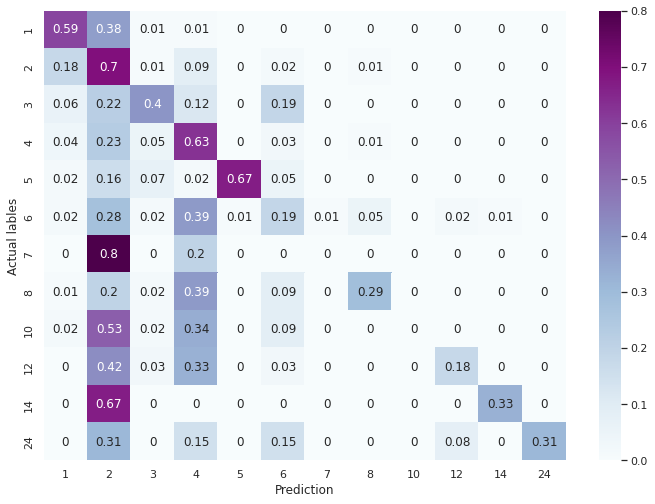

In [ ]:
confusion_matrix_orly_pred = pd.crosstab(proba_pred_actual['nsub'].astype(int), y_prob_df_with_true_labels_local["orly_pred"].astype(int), rownames=['Actual'], colnames=['Predicted'] )

confusion_matrix_orly_pred_percent = confusion_matrix_orly_pred.div(confusion_matrix_orly_pred.sum(axis=1), axis=0).round(2)
s = sns.heatmap(confusion_matrix_orly_pred_percent, annot=True, fmt='g', cmap="BuPu")
s.set(xlabel='Prediction', ylabel='Actual lables')

In [ ]:
y_prob_df_with_true_labels_local.iloc[4980]

1             0.000756
2             0.013562
3             0.003995
4             0.018128
5             0.001709
6             0.002385
7             0.000145
8             0.001786
10            0.001132
12            0.088116
14            0.004173
24            0.864113
nsub         24.000000
orly_pred    24.000000
Name: 4980, dtype: float64